Importing tools for data preprocessing, machine learning, evaluation, and audio analysis.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_sample_weight

This code loads the development.csv and evaluation.csv files into Pandas DataFrames (development_data and evaluation_data) for training and testing purposes.

In [58]:
development_data = pd.read_csv("development.csv")
evaluation_data = pd.read_csv("evaluation.csv")



This code defines a function to convert the tempo column from a string to a float by stripping brackets and changing the data type, then applies it to both the development_data and evaluation_data DataFrames.

In [59]:
def process_tempo_column(df):
    df['tempo'] = (
        df['tempo']
        .astype(str)        # force string
        .str.strip('[]')   # remove brackets
        .astype(float)     # convert
    )
    return df

In [60]:
development_data = process_tempo_column(development_data)
evaluation_data = process_tempo_column(evaluation_data)



This code shuffles the rows of the development_data DataFrame randomly while keeping the order reproducible by setting random_state=42.

In [61]:
# Shuffle the data
development_data = shuffle(development_data, random_state=42)

This code defines two feature sets for the model:

numerical_features: A list of numerical columns used as input features (e.g., pitch, energy, tempo).

categorical_features: A list of categorical columns (gender and ethnicity) requiring encoding before use.

In [94]:
numerical_features = [
    'sampling_rate', 'mean_pitch', 'max_pitch', 'min_pitch',
    'jitter', 'shimmer', 'energy', 'zcr_mean',
    'spectral_centroid_mean', 'tempo',
    'num_words', 'num_characters', 'num_pauses', 'silence_duration'
]

categorical_features = ['gender', 'ethnicity']



This code defines preprocessing pipelines:

Numerical Data: Handles missing values with the median (SimpleImputer) and scales features (StandardScaler).

Categorical Data: Imputes missing values with the most frequent value and encodes categories using one-hot encoding (OneHotEncoder).

Combine Preprocessors: Uses ColumnTransformer to apply the numerical and categorical pipelines to their respective feature sets.

In [95]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])



This code defines two separate pipelines for the models:

pipeline_rf: Combines the preprocessing steps with a RandomForestRegressor for model training.

pipeline_gbr: Combines the preprocessing steps with a GradientBoostingRegressor for model training. Both pipelines ensure consistent preprocessing and model fitting in one step.

In [96]:
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

pipeline_gbr = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])



The distribution of categorical features, especially ethnicity, is highly imbalanced, with a few groups containing most samples and many groups having very few observations. This may bias the model toward majority classes. To mitigate this issue, sample weighting was applied during training to improve fairness and generalization.


In [97]:
development_data['ethnicity'].value_counts()

ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
edo            1
faroese        1
ebira          1
konkani        1
kabyle         1
Name: count, Length: 165, dtype: int64

In [98]:
sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=development_data["ethnicity"]
)


This code splits the development_data into features (X) and target (y), then further splits them into training and testing sets using train_test_split, with 20% of the data reserved for testing (test_size=0.2). The random_state=42 ensures reproducibility.

In [99]:
X = development_data[numerical_features + categorical_features]
y = development_data["age"]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights,
    test_size=0.2,
    random_state=42
)



This code defines parameter grids (param_distributions_rf and param_distributions_gbr) for hyperparameter tuning using RandomizedSearchCV for both models. It then combines the models (RandomForest and GradientBoosting) with their respective parameter grids into a dictionary (pipelines) for easier reference and tuning.

In [100]:
param_grid_rf = {
    "model__n_estimators": [300, 500, 700],
    "model__max_depth": [None, 20, 30, 40],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", 0.7]
}

param_grid_gbr = {
    "model__n_estimators": [400, 600, 800],
    "model__learning_rate": [0.03, 0.05, 0.07],
    "model__max_depth": [3, 4, 5],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__subsample": [0.7, 0.8, 0.9]
}



pipelines = {
    "RandomForest": (pipeline_rf, param_grid_rf),
    "GradientBoosting": (pipeline_gbr, param_grid_gbr)
}


This code performs hyperparameter optimization using RandomizedSearchCV for both the RandomForest and GradientBoosting models, testing 50 random combinations of hyperparameters. It also evaluates the models' performance by calculating the mean squared error (MSE) on both the training and test sets for various values of n_estimators. The best model is selected based on the lowest MSE across iterations, with the results stored in a dictionary (results). The model with the best score is saved as best_model.

In [85]:
# =========================================================
# Grid Search Training + Evaluation
# =========================================================

best_model = None
best_score = float("inf")
best_name = ""
results = {}   # <-- store metrics for plotting


for name, (pipe, grid) in pipelines.items():

    print(f"\nOptimizing {name}")

    search = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="neg_mean_squared_error",
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    # fit with weights
    search.fit(X_train, y_train, model__sample_weight=w_train)

    mse = -search.best_score_

    print("Best params:", search.best_params_)
    print("CV MSE:", mse)

    # save best model
    if mse < best_score:
        best_score = mse
        best_model = search.best_estimator_
        best_name = name


# =========================================================
# Evaluate best model
# =========================================================
print(f"\nBest overall model: {best_name}")

y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test  RMSE: {test_rmse:.3f}")


# =========================================================
# Build results dictionary (for plotting later)
# =========================================================
for name, (pipe, grid) in pipelines.items():

    results[name] = {}
    n_list = grid["model__n_estimators"]

    for n in n_list:

        model = pipe.set_params(model__n_estimators=n)

        model.fit(X_train, y_train, model__sample_weight=w_train)

        train_pred = model.predict(X_train)
        test_pred  = model.predict(X_test)

        results[name][n] = {
            "train_mse": mean_squared_error(y_train, train_pred),
            "test_mse":  mean_squared_error(y_test, test_pred)
        }



Optimizing RandomForest
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best params: {'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
CV MSE: 117.15169147249945

Optimizing GradientBoosting
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best params: {'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 600, 'model__subsample': 0.7}
CV MSE: 112.52118442031684

Best overall model: GradientBoosting
Train RMSE: 7.252
Test  RMSE: 9.895


This code evaluates the best model from the hyperparameter search, printing the model name and calculating the Root Mean Squared Error (RMSE) for both training and test sets. It then predicts values on the evaluation dataset and saves the predictions in a new CSV file (submission.csv), rounding the predicted values to one decimal place. The results are stored in the submission DataFrame, which is then saved to disk.

In [86]:


# =========================================================
# Final training on ALL data
# =========================================================
print(f"\nTraining final best model on full dataset: {best_name}")


best_model.fit(X, y)




# =========================================================
# Predict evaluation set
# =========================================================
eval_X = evaluation_data[numerical_features + categorical_features]
predictions = best_model.predict(eval_X)

print("Prediction shape:", predictions.shape)


# =========================================================
# Save submission
# =========================================================
submission = pd.DataFrame({
    "Id": evaluation_data["Id"],
    "Predicted": np.round(predictions, 1)
})

submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")



Training final best model on full dataset: GradientBoosting
Prediction shape: (691,)
Submission file created: submission.csv



This code generates a plot to compare the training and testing Mean Squared Error (MSE) for different values of n_estimators in both RandomForest and GradientBoosting models. It uses the results stored in the results dictionary and plots the MSE for each model, with markers for each n_estimators value. The plot helps visualize how performance changes with the number of estimators, showing both train and test errors for comparison.

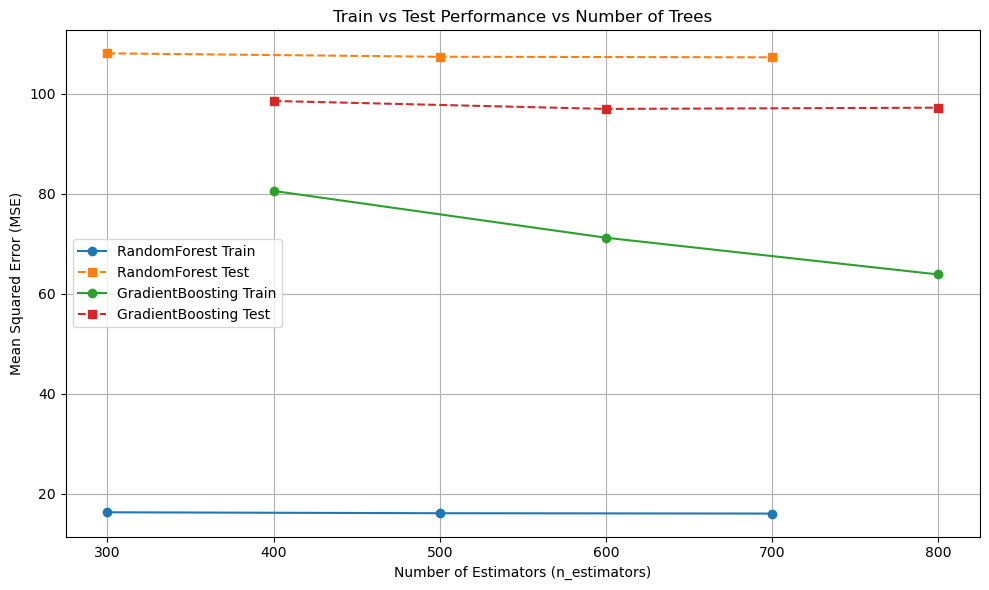

In [101]:
# =========================================================
# Plot results
# =========================================================

plt.figure(figsize=(10, 6))

for model_name in results:

    # choose correct grid per model
    if model_name == "RandomForest":
        n_list = param_grid_rf["model__n_estimators"]
    else:
        n_list = param_grid_gbr["model__n_estimators"]

    train_mse = [results[model_name][n]['train_mse'] for n in n_list]
    test_mse  = [results[model_name][n]['test_mse']  for n in n_list]

    plt.plot(n_list, train_mse, marker='o', label=f'{model_name} Train')
    plt.plot(n_list, test_mse, marker='s', linestyle='--', label=f'{model_name} Test')


plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Train vs Test Performance vs Number of Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



This code generates a heatmap using Seaborn to visualize the correlation between the numerical features and the target variable age in the development_data. The heatmap shows the correlation coefficients, with color intensity indicating the strength of the relationship. 

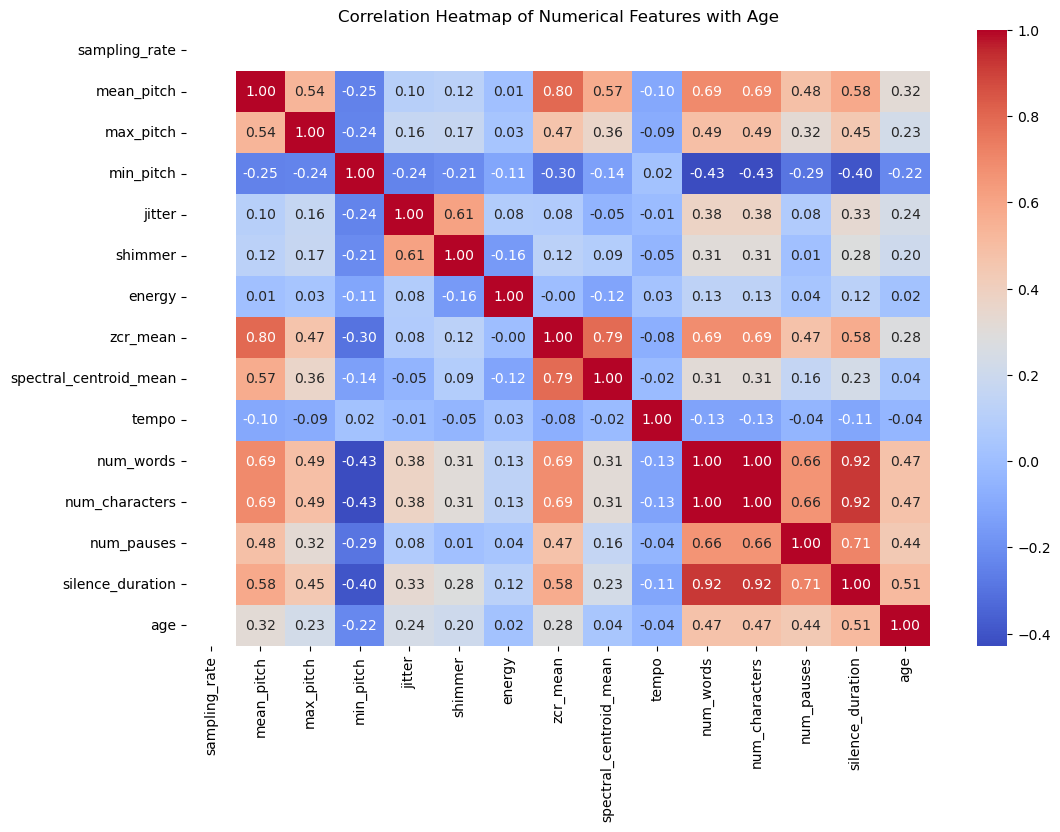

In [102]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(development_data[numerical_features + ['age']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features with Age")
plt.show()


This code calculates the median tempo in the development_data, finds the corresponding ID, and loads the audio file for that ID to plot its waveform using librosa. The audio files must be stored in the audios_development/ directory with filenames matching the ID values.

Median Tempo: 117.45383523
ID of the Median Tempo: 1195


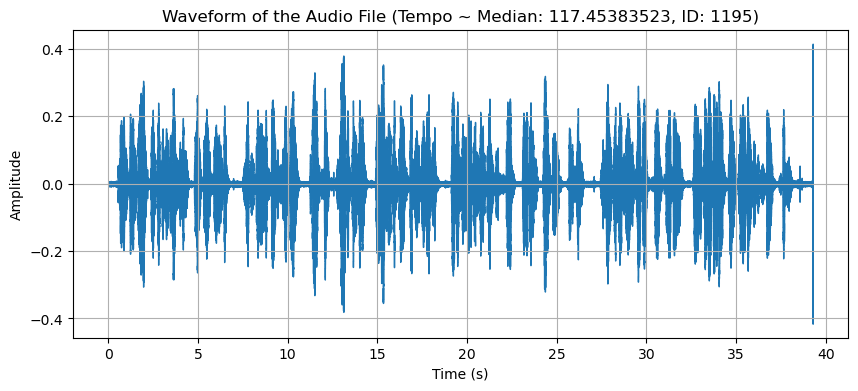

In [103]:
import librosa
#Calculate the median tempo
median_tempo = development_data['tempo'].median()

# Find the ID corresponding to the median tempo
median_tempo_id = development_data.loc[development_data['tempo'] == median_tempo, 'Id'].iloc[0]

print(f"Median Tempo: {median_tempo}")
print(f"ID of the Median Tempo: {median_tempo_id}")

# Generate or load an audio signal for the plot
# Use f-string to dynamically load the audio file based on the median_tempo_id
audio_file_path = f"{median_tempo_id}.wav"  # The audio file name should match the ID
y, sr = librosa.load(audio_file_path)

# Create the waveform plot
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of the Audio File (Tempo ~ Median: {median_tempo}, ID: {median_tempo_id})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()



This code generates a histogram with a Kernel Density Estimate (KDE) for the age column in the development_data DataFrame. It visualizes the distribution of ages, with the histogram showing the frequency of age values and the KDE providing a smoothed curve of the data's distribution. The plot helps understand the age distribution and its shape.

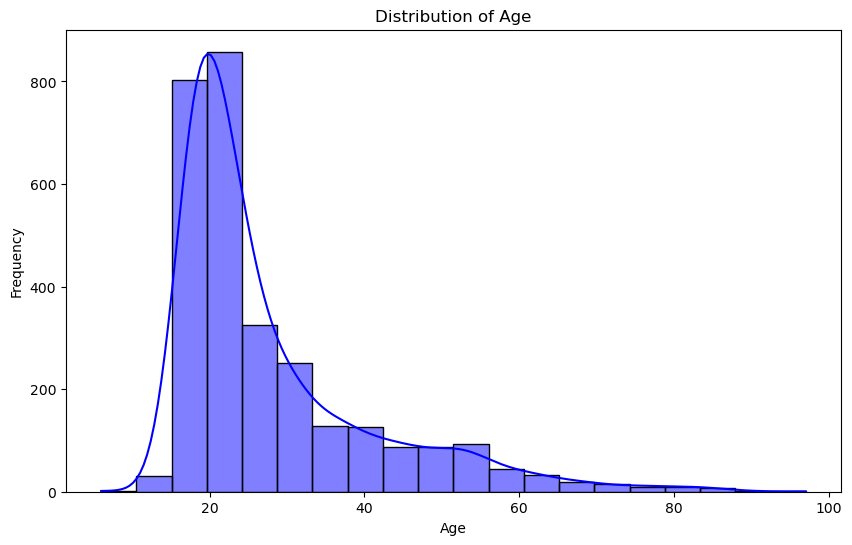

In [104]:
plt.figure(figsize=(10, 6))
sns.histplot(development_data['age'], kde=True, bins=20, color='blue')
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()



This code calculates and visualizes the mean age for the top 10 most common ethnicities in the development_data DataFrame. It first identifies the top 10 ethnicities based on frequency, then computes the average age for each. The results are displayed in a bar chart, where the bars represent the mean age for each ethnicity, sorted in ascending order for easy comparison. The plot helps analyze the age distribution across different ethnicities.

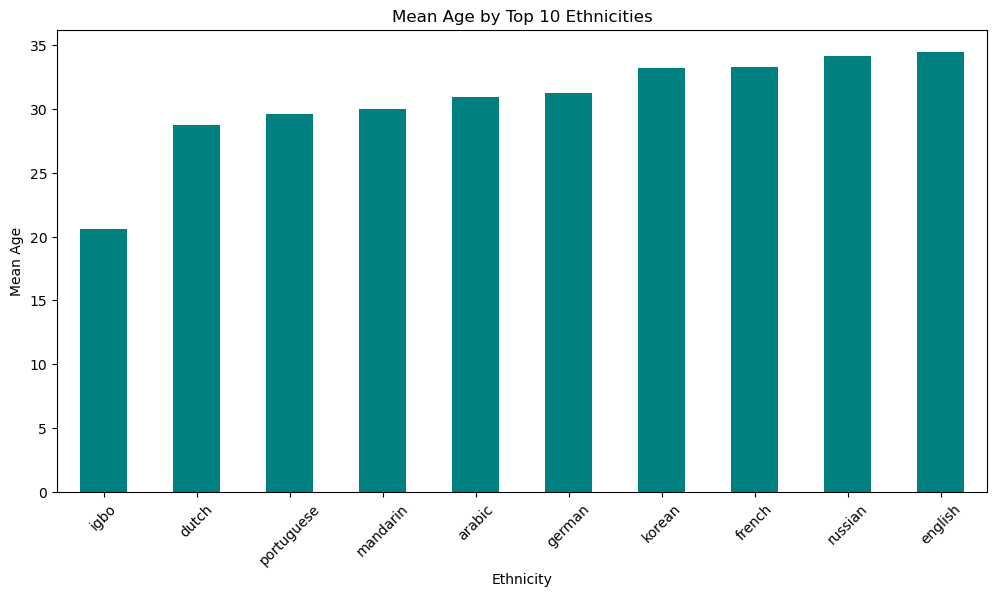

In [105]:

#  Mean Age by Ethnicity (Top 10 Ethnicities)
top_ethnicities = development_data['ethnicity'].value_counts().head(10).index
ethnicity_means = development_data[development_data['ethnicity'].isin(top_ethnicities)].groupby('ethnicity')['age'].mean()

plt.figure(figsize=(12, 6))
ethnicity_means.sort_values().plot(kind='bar', color='teal')
plt.title("Mean Age by Top 10 Ethnicities")
plt.xlabel("Ethnicity")
plt.ylabel("Mean Age")
plt.xticks(rotation=45)
plt.show()